# Report

1. One wrong record found in ArgumentationTime feature, see ArgumentationTime feature visualization.  
2. The perjob features matrix is sparse. I doubt if the current features are all useful for research. Stefan said he needs more features for predicting his response, but the actual amount of predictors may be less than we thought.
3. Aggregate features all show long tail and right-skewed. But outliers may be meaningful for detecting players' behaviral pattern.  
4. One wrong record found in ExperimentationTime feature, see Aggregate feature visualization.
5. Interesting thing: Why there are more switch_job_count than job_completion?

# Environment Setup and Import

In [1]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras
import os
print(os.getcwd())
!pip install --quiet -r ../../requirements.txt

2023-03-30 15:53:32.437266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 15:53:35.253097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 15:53:35.253135: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-30 15:53:41.814279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

/workspaces/opengamedata-samples/AQUALAB/templates


Change pandas `max_rows` and `max_columns`

In [2]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Load Data

#### Please change `ogd_server` and `zip_name` if you want to get a file from a different location.
#### This cell will error if `ogd_server` and `zip_name` are invalid.

In [3]:
ogd_server = 'http://opengamedata.fielddaylab.wisc.edu/'
server_data_path = 'data/AQUALAB/'
dataset_name = "AQUALAB_20230101_to_20230131"
zip_name = f"{dataset_name}_7565f43_player-features.zip"

file_url = f"{ogd_server}{server_data_path}{zip_name}"

# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {ogd_server}...")
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

In [4]:
# Open TSV from the zip file.
# Errors out, not a zip file
#zip_file = ZipFile(Path(f'./{zip_name}'))
# tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
# raw_data = pd.DataFrame()
# with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
#     raw_data = pd.read_csv(tsv_file, sep='\t')
# data_readme = zip_file.read(f"{dataset_name}/readme.md")
# zip_file.close()

In [5]:
# Get file path and create data frame
tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
survey_path = Path("./") / dataset_name / tsv_name
if not survey_path.is_file():
    !unzip ./{zipname} -d {dataset_name}
raw_data = pd.read_csv(survey_path, sep='\t')

In [6]:
raw_data
for col, dtype in zip(raw_data, raw_data.dtypes):
  if dtype == "string":
    try:
      raw_data[col] = pd.to_timedelta(typed_draw_dataata[col])
    except:
      try:
        typed_draw_dataata[col] = pd.to_numeric(raw_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        raw_data[col] = pd.to_numeric(raw_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{raw_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{raw_data.dtypes}")

This dataframe contains data of the following types:
[dtype('O') dtype('int64') dtype('float64')]

Per feature, the data types are:
PlayerID                                     object
SessionCount                                  int64
ActiveTime                                   object
JobsCompleted                                object
SessionDiveSitesCount                         int64
                                             ...   
job60_JobsAttempted-num-completes             int64
job60_JobsAttempted-percent-complete          int64
job60_JobsAttempted-avg-time-per-attempt    float64
job60_JobsAttempted-std-dev-per-attempt       int64
job60_JobsAttempted-job-difficulties         object
Length: 1359, dtype: object


In [7]:
raw_data

PlayerID  SessionCount        ActiveTime   
0               NaN             1         No events  \
1        AbruptSign             1           0:01:32   
2     AbsorbedComma             6   1 day, 22:19:00   
3     AbstractRobin             2  -1 day, 23:12:25   
4    AccusingSonnet             5  -3 days, 2:41:08   
..              ...           ...               ...   
950   WatchfulGuest             1           0:05:28   
951     WigglyMetro             1           0:02:11   
952        WildNote             2           2:49:38   
953   WishfulBasics             1           0:17:28   
954   WrittenRefund             1           0:00:53   

                                         JobsCompleted  SessionDiveSitesCount   
0                                                   []                      0  \
1                                                   []                      0   
2    ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
3    ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
4    ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
..                                                 ...                    ...   
950                                                 []                      0   
951                                                 []                      0   
952  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                      4   
953          ['kelp-welcome', 'kelp-bull-kelp-forest']                      2   
954                                                 []                      0   

     SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                    0                 0    player                     0  \
1                    0                 0    player                     0   
2                    0                42    player                    33   
3                    0                24    player                    15   
4                    0                25    player                    16   
..                 ...               ...       ...                   ...   
950                  0                 0    player                     0   
951                  0                 0    player                     0   
952                  0                 5    player                     3   
953                  0                 0    player                     2   
954                  0                 0    player                     0   

     SwitchJobsCount                       TopJobCompletionDestinations   
0                  0                                                 {}  \
1                  0                                                 {}   
2                 82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
3                 36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
4                 32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
..               ...                                                ...   
950                2                                                 {}   
951                1                                                 {}   
952                7  {"kelp-welcome": {"kelp-bull-kelp-forest": ["W...   
953                5  {"kelp-welcome": {"kelp-bull-kelp-forest": ["W...   
954                0                                                 {}   

                              TopJobSwitchDestinations TotalArgumentationTime   
0                                                   {}                0:00:00  \
1                                                   {}                0:00:00   
2    {"no-active-job": {"arctic-missing-whale": ["A...                0:44:24   
3    {"no-active-job": {"arctic-missing-whale": ["A...                0:14:18   
4    {"no-active-job": {"coral-turtle-population": ...                0:25:36   
..                                                 ...                    ...

In [9]:
#@markdown Do you want to filter player list?
Answer  = False#@param {type:"boolean"}
#@markdown Please change the file path if your player list is located differently.
PL_Path = "PlayerList.txt"#@param {type:"string"}
if Answer:
  player_list = pd.read_csv(JUPYTER_DIR / Path(PL_Path), sep='t', names=["Player"])
  raw_data = raw_data[raw_data.PlayerId.isin()]

In [10]:
df_session = raw_data.dropna()


#### Type Conversions

In [40]:
for col, dtype in zip(df_session, df_session.dtypes):
  if dtype == "string":
    try:
      df_session[col] = pd.to_timedelta(df_session[col])
    except:
      pass

In [41]:
#Parameters for cleaning

#@markdown Type a perjob feature name here
Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}
id_columns = pd.Index(["SessionID", "PlayerID"])

In [70]:
# change interested columns into strings
# #dtypes for all columns
df_Interested = df_Interested.convert_dtypes()

In [44]:
#if dtype is string, change to timedelta if possible
for col, dtype in zip(df_Interested, df_Interested.dtypes):
  if dtype == "string":
    try:
      df_Interested[col] = pd.to_timedelta(df_Interested[col])
    except:
      pass

In [69]:
#data frame we want to change to time delta
target_columns = df_Interested.columns[df_Interested.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_Interested[id_columns.append(target_columns)].copy()
df_Interested.head()

,SessionID,PlayerID,TotalArgumentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job60_JobArgumentationTime
1,player,AbruptSign,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
2,player,AbsorbedComma,0:44:24,0:00:00,0:02:23,0:00:00,0:00:00,0:00:53,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:34,0:00:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:08,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:40,0:00:00,0:00:15,0:00:00,0:00:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
3,player,AbstractRobin,0:14:18,0:00:00,0:00:00,0:00:00,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:25,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:43,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
4,player,AccusingSonnet,0:25:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:05:49,0:00:00,0:00:24,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:07,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:49,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
5,player,AcidHumor,1:21:07,0:00:00,0:16:04,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:02:52,0:00:00,0:00:00,0:00:00,0:02:07,0:00:00,0:00:00,0:15:32,0:00:00,0:01:03,0:02:12,0:00:00,0:00:39,0:00:00,0:00:27,0:02:52,0:02:21,0:0

In [46]:
#turn time into seconds
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()
df_Interested.dtypes

SessionID                     string[python]
PlayerID                      string[python]
TotalArgumentationTime               float64
job0_JobArgumentationTime            float64
job1_JobArgumentationTime            float64
                                   ...      
job56_JobArgumentationTime           float64
job57_JobArgumentationTime           float64
job58_JobArgumentationTime           float64
job59_JobArgumentationTime           float64
job60_JobArgumentationTime           float64
Length: 64, dtype: object

In [47]:
#find outliers of what columns
outlier = 4000 #@param {type:"integer"}
bigoutliers = np.where(df_Interested[target_columns].ge(outlier)) 
#df of outliers
df_Interested[target_columns].iloc[bigoutliers]

,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job35_JobArgumentationTime,job48_JobArgumentationTime,job35_JobArgumentationTime,TotalArgumentationTime,job36_JobArgumentationTime,job36_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job2_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job16_JobArgumentationTime,job22_JobArgumentationTime,TotalArgumentationTime,job24_JobArgumentationTime,TotalArgumentationTime,job1_JobArgumentationTime
5,4867.0,4867.0,4867.0,21.0,0.0,21.0,4867.0,0.0,0.0,4867.0,4867.0,4867.0,4867.0,4867.0,0.0,4867.0,4867.0,4867.0,4867.0,0.0,39.0,4867.0,27.0,4867.0,964.0
36,4805.0,4805.0,4805.0,13.0,0.0,13.0,4805.0,0.0,0.0,4805.0,4805.0,4805.0,4805.0,4805.0,0.0,4805.0,4805.0,4805.0,4805.0,0.0,144.0,4805.0,131.0,4805.0,541.0
39,4759.0,4759.0,4759.0,32.0,25.0,32.0,4759.0,0.0,0.0,4759.0,4759.0,4759.0,4759.0,4759.0,0.0,4759.0,4759.0,4759.0,4759.0,29.0,35.0,4759.0,8.0,4759.0,23.0
40,1408.0,1408.0,1408.0,86100.0,0.0,86100.0,1408.0,0.0,0.0,1408.0,1408.0,1408.0,1408.0,1408.0,0.0,1408.0,1408.0,1408.0,1408.0,0.0,0.0,1408.0,0.0,1408.0,0.0
107,492.0,492.0,492.0,0.0,86211.0,0.0,492.0,0.0,0.0,492.0,492.0,492.0,492.0,492.0,0.0,492.0,492.0,492.0,492.0,0.0,0.0,492.0,0.0,492.0,0.0
120,200.0,200.0,200.0,86168.0,0.0,86168.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,200.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,200.0,0.0,200.0,0.0
150,7765.0,7765.0,7765.0,0.0,11.0,0.0,7765.0,0.0,0.0,7765.0,7765.0,7765.0,7765.0,7765.0,0.0,7765.0,7765.0,7765.0,7765.0,0.0,0.0,7765.0,0.0,7765.0,0.0
156,3390.0,3390.0,3390.0,0.0,33.0,0.0,3390.0,85155.0,85155.0,3390.0,3390.0,3390.0,3390.0,3390.0,0.0,3390.0,3390.0,3390.0,3390.0,0.0,0.0,3390.0,8.0,3390.0,25.0
173,941.0,941.0,941.0,0.0,0.0,0.0,941.0,87075.0,87075.0,941.0,941.0,941.0,941.0,941.0,0.0,941.0,941.0,941.0,941.0,0.0,0.0,941.0,28.0,941.0,168.0
177,78600.0,78600.0,78600.0,219.0,0.0,219.0,78600.0,0.0,0.0,78600.0,78600.0,78600.0,78600.0,78600.0,0.0,78600.0,78600.0,78600.0,78600.0,0.0,0.0,78600.0,0.0,78600.0,179.0


# Overview

## Data Overview

In [48]:
split depending on prefix, clean columns
cols_split = []
for col in df_session.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job') or prefix.startswith('int') or prefix.startswith('obj') \
  or prefix.startswith('SA')  or prefix.startswith('Q'):
    cols_split.append(pieces[1])
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(df_session.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

1359 Columns in 39 groups:
Counter({'JobActiveTime': 61,
         'JobArgumentationTime': 61,
         'JobCompletionTime': 61,
         'JobDiveSitesCount': 61,
         'JobDiveTime': 61,
         'JobExperimentationTime': 61,
         'JobGuideCount': 61,
         'JobHelpCount': 61,
         'JobHelpCount-ByTask': 61,
         'JobLocationChanges': 61,
         'JobLocationChanges-ByTask': 61,
         'JobModelingTime': 61,
         'JobTasksCompleted': 61,
         'SyncCompletionTime': 61,
         'JobsAttempted': 61,
         'JobsAttempted-job-name': 61,
         'JobsAttempted-num-starts': 61,
         'JobsAttempted-num-completes': 61,
         'JobsAttempted-percent-complete': 61,
         'JobsAttempted-avg-time-per-attempt': 61,
         'JobsAttempted-std-dev-per-attempt': 61,
         'JobsAttempted-job-difficulties': 61,
         'PlayerID': 1,
         'SessionCount': 1,
         'ActiveTime': 1,
         'JobsCompleted': 1,
         'SessionDiveSitesCount': 1,
     

In [50]:
#data types in each column
df_session.dtypes

PlayerID                                     object
SessionCount                                  int64
ActiveTime                                   object
JobsCompleted                                object
SessionDiveSitesCount                         int64
                                             ...   
job60_JobsAttempted-num-completes             int64
job60_JobsAttempted-percent-complete          int64
job60_JobsAttempted-avg-time-per-attempt    float64
job60_JobsAttempted-std-dev-per-attempt       int64
job60_JobsAttempted-job-difficulties         object
Length: 1359, dtype: object

In [51]:
df_session.head()

PlayerID  SessionCount        ActiveTime   
1      AbruptSign             1           0:01:32  \
2   AbsorbedComma             6   1 day, 22:19:00   
3   AbstractRobin             2  -1 day, 23:12:25   
4  AccusingSonnet             5  -3 days, 2:41:08   
5       AcidHumor            32   2 days, 6:11:09   

                                       JobsCompleted  SessionDiveSitesCount   
1                                                 []                      0  \
2  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
3  ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
4  ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
5  ['coral-fake-fix', 'coral-lionfish-conspiracy'...                     11   

   SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
1                  0                 0    player                     0  \
2                  0                42    player                    33   
3                  0                24    player                    15   
4                  0                25    player                    16   
5                  0                42    player                    22   

   SwitchJobsCount                       TopJobCompletionDestinations   
1                0                                                 {}  \
2               82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
3               36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
4               32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
5               69  {"coral-fake-fix": {"coral-lionfish-conspiracy...   

                            TopJobSwitchDestinations TotalArgumentationTime   
1                                                 {}                0:00:00  \
2  {"no-active-job": {"arctic-missing-whale": ["A...                0:44:24   
3  {"no-active-job": {"arctic-missing-whale": ["A...                0:14:18   
4  {"no-active-job": {"coral-turtle-population": ...                0:25:36   
5  {"no-active-job": {"coral-stressed": ["AcidHum...                1:21:07   

  TotalDiveTime TotalExperimentationTime  job0_JobActiveTime   
1       0:00:00                  0:00:00                 0.0  \
2       0:11:17                  0:50:29             10572.0   
3       0:02:02                  0:08:00               108.0   
4       0:03:17                  0:08:53            235416.0   
5       0:12:51                  0:31:21           5432385.0   

   job1_JobActiveTime  job2_JobActiveTime  job3_JobActiveTime   
1                 0.0                 0.0                 0.0  \
2              2469.0               193.0                 0.0   
3               678.0                 0.0                 0.0   
4               479.0                 0.0                 0.0   
5              3333.0                 0.0                 0.0   

   job4_JobActiveTime  job5_JobActiveTime  job6_JobActiveTime   
1                 0.0                 0.0                 0.0  \
2               279.0                 0.0                 0.0   
3               388.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5               238.0                 0.0                 0.0   

   job7_JobActiveTime  job8_JobActiveTime  job9_JobActiveTime   
1                 0.0                 0.0                 0.0  \
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5                 0.0                 0.0                 0.0   

   job10_JobActiveTime  job11_JobActiveTime  job12_JobActiveTime   
1                  0.0                  0.0                  0.0  \
2                469.0                  0.0               3611.0   
3                  0.0                  0.0                  0.0   
4                  0.0    

In [52]:
#Data frame to analyze
target = 'job' #@param {type:"string"}
target_columns = df_session.columns[~df_session.columns.str.contains(target)]
df_Aggregate = df_session[target_columns].copy()
df_Aggregate

,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration
1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0:00:00,0:00:00,0:00:00,92.000000,92.0
2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:44:24,0:11:17,0:50:29,5289.833333,31739.0
3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:14:18,0:02:02,0:08:00,5308.000000,10616.0
4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",0:25:36,0:03:17,0:08:53,2271.000000,11355.0
5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",1:21:07,0:12:51,0:31:21,6748.031250,215937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0:00:00,0:00:00,0:00:00,776.000000,776.0
951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0:00:00,0:00:00,0:00:00,669.000000,669.0
952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:04:24,0:01:44,0:02:48,1637.500000,3275.0
953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:02:55,0:00:51,0:01:07,1487.000000,1487.0


# Visualizations

Amount of players

In [114]:
#Amount of unique PlayerIDs - amount of players
len(df_Aggregate['PlayerID'])

954

How long did they play?

In [115]:
df_column = df_session['UserTotalSessionDuration'] #column must be integers

The average time spent was 7755.409853249476


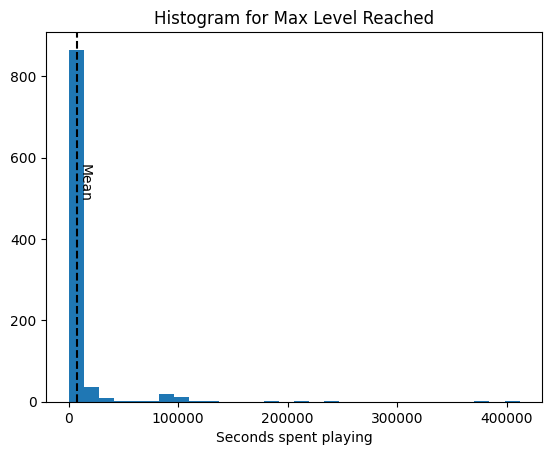

In [116]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Seconds spent playing")
ax.set_title("Histogram for Max Level Reached")
print(f'The average time spent was {df_column.mean()}')

How far did the players get?

In [117]:

#@parameter
df_column = df_session['SessionJobsCompleted'] #column must be integers

The average  completed level was 3.0964360587002098


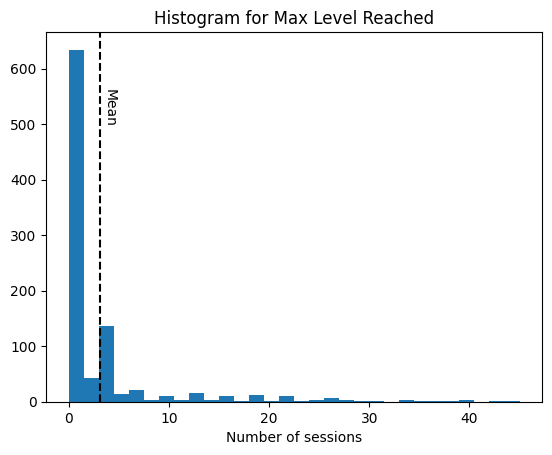

In [118]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Number of sessions")
ax.set_title("Histogram for Max Level Reached")
print(f'The average  completed level was {df_column.mean()}')

X vs Y Scatter Plot

In [119]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

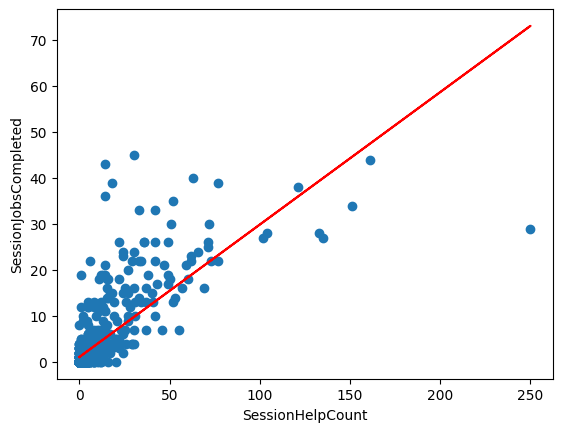

In [120]:
plt.scatter(df_session[col1], df_session[col2])
m, b = np.polyfit(df_session[col1], df_session[col2], 1)
plt.plot(df_session[col1], m*df_session[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)

Amount of Sessions vs Avg Length of Session

In [122]:
#scatter plot columns
col1 = 'SessionCount' #@param{type:"string"}
col2 = 'UserAvgSessionDuration'#@param{type:"string"}

Text(0, 0.5, 'UserAvgSessionDuration')

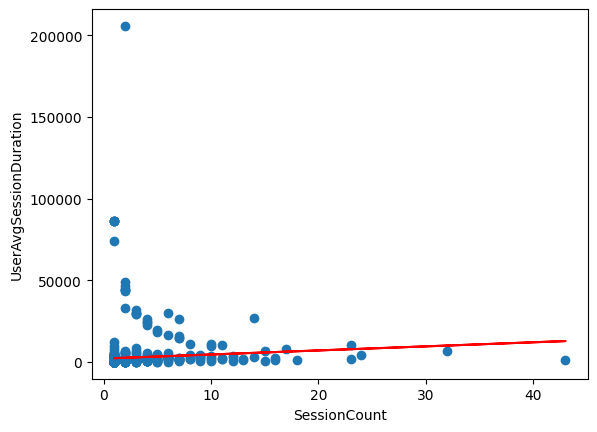

In [123]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
m, b = np.polyfit(df_Aggregate[col1], df_Aggregate[col2], 1)
plt.plot(df_Aggregate[col1], m*df_Aggregate[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)

In [131]:
features1=list(['SessionHelpCount','SessionJobsCompleted','UserTotalSessionDuration'])

df_Aggregate[features1].corr()


,SessionHelpCount,SessionJobsCompleted,UserTotalSessionDuration
SessionHelpCount,1.000000,0.761454,0.418558
SessionJobsCompleted,0.761454,1.000000,0.520789
UserTotalSessionDuration,0.418558,0.520789,1.000000


Heatmap

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
       # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)

In [124]:
df_Aggregate

,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration
1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0:00:00,0:00:00,0:00:00,92.000000,92.0
2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:44:24,0:11:17,0:50:29,5289.833333,31739.0
3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:14:18,0:02:02,0:08:00,5308.000000,10616.0
4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",0:25:36,0:03:17,0:08:53,2271.000000,11355.0
5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",1:21:07,0:12:51,0:31:21,6748.031250,215937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0:00:00,0:00:00,0:00:00,776.000000,776.0
951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0:00:00,0:00:00,0:00:00,669.000000,669.0
952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:04:24,0:01:44,0:02:48,1637.500000,3275.0
953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:02:55,0:00:51,0:01:07,1487.000000,1487.0


In [125]:
df_Aggregate.head(387)

,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration
1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0:00:00,0:00:00,0:00:00,92.000000,92.0
2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:44:24,0:11:17,0:50:29,5289.833333,31739.0
3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:14:18,0:02:02,0:08:00,5308.000000,10616.0
4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",0:25:36,0:03:17,0:08:53,2271.000000,11355.0
5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",1:21:07,0:12:51,0:31:21,6748.031250,215937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,RamblingMoon,3,3:18:44,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",10,0,33,player,22,55,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""R...","{""arctic-missing-whale"": {""displaced-reef"": [""...",0:38:18,0:05:09,0:17:20,8618.000000,25854.0
384,RandomGraft,1,0:18:03,['kelp-welcome'],2,0,1,player,1,3,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""R...",{},0:01:24,0:00:41,0:01:26,1290.000000,1290.0
385,RealSting,1,0:19:13,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,3,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""R...",{},0:04:13,0:00:26,0:01:48,1328.000000,1328.0
386,RecentRipple,1,0:03:30,[],0,0,0,player,0,1,{},{},0:00:00,0:00:00,0:00:00,303.000000,303.0


In [126]:
outlier = 100000 #@param {type:"integer"}
target_col = 'UserAvgSessionDuration'
bigoutliers = np.where(df_Aggregate[target_col].ge(outlier)) 
#df of outliers
print(bigoutliers)
df_Aggregate[target_col].drop(df_Aggregate[target_col].loc[bigoutliers])
#df_Aggregate.head(387)

(array([386]),)


1        92.000000
2      5289.833333
3      5308.000000
4      2271.000000
5      6748.031250
          ...     
950     776.000000
951     669.000000
952    1637.500000
953    1487.000000
954      53.000000
Name: UserAvgSessionDuration, Length: 953, dtype: float64

## ArgumentationTime feature visualization

### removing outliers

In [127]:
# #@markdown Type a perjob feature name here
# Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
# #@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
# Answer  = True#@param {type:"boolean"}


In [128]:
# id_columns = pd.Index(["SessionID", "PlayerID"])

In [129]:
target_columns = df_session.columns[df_session.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_session[id_columns.append(target_columns)].copy()
df_Interested.head()

,SessionID,PlayerID,TotalArgumentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job60_JobArgumentationTime
1,player,AbruptSign,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
2,player,AbsorbedComma,0:44:24,0:00:00,0:02:23,0:00:00,0:00:00,0:00:53,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:34,0:00:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:08,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:40,0:00:00,0:00:15,0:00:00,0:00:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
3,player,AbstractRobin,0:14:18,0:00:00,0:00:00,0:00:00,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:25,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:43,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
4,player,AccusingSonnet,0:25:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:05:49,0:00:00,0:00:24,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:07,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:49,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
5,player,AcidHumor,1:21:07,0:00:00,0:16:04,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:02:52,0:00:00,0:00:00,0:00:00,0:02:07,0:00:00,0:00:00,0:15:32,0:00:00,0:01:03,0:02:12,0:00:00,0:00:39,0:00:00,0:00:27,0:02:52,0:02:21,0:0

Execute the following chunk only when the features are timedelta

In [130]:
#turn time into seconds
df_Interested = df_Interested.convert_dtypes()
df_Interested.dtypes
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
outlier = 4000 #@param {type:"integer"}
bigoutliers = np.where(df_Interested[target_columns].ge(outlier)) 
bigoutliers

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
#df of outliers
df_Interested[target_columns].iloc[bigoutliers]

,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job35_JobArgumentationTime,job48_JobArgumentationTime,job35_JobArgumentationTime,TotalArgumentationTime,job36_JobArgumentationTime,job36_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job2_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job16_JobArgumentationTime,job22_JobArgumentationTime,TotalArgumentationTime,job24_JobArgumentationTime,TotalArgumentationTime,job1_JobArgumentationTime
5,1:21:07,1:21:07,1:21:07,0:00:21,0:00:00,0:00:21,1:21:07,0:00:00,0:00:00,1:21:07,1:21:07,1:21:07,1:21:07,1:21:07,0:00:00,1:21:07,1:21:07,1:21:07,1:21:07,0:00:00,0:00:39,1:21:07,0:00:27,1:21:07,0:16:04
36,1:20:05,1:20:05,1:20:05,0:00:13,0:00:00,0:00:13,1:20:05,0:00:00,0:00:00,1:20:05,1:20:05,1:20:05,1:20:05,1:20:05,0:00:00,1:20:05,1:20:05,1:20:05,1:20:05,0:00:00,0:02:24,1:20:05,0:02:11,1:20:05,0:09:01
39,1:19:19,1:19:19,1:19:19,0:00:32,0:00:25,0:00:32,1:19:19,0:00:00,0:00:00,1:19:19,1:19:19,1:19:19,1:19:19,1:19:19,0:00:00,1:19:19,1:19:19,1:19:19,1:19:19,0:00:29,0:00:35,1:19:19,0:00:08,1:19:19,0:00:23
40,0:23:28,0:23:28,0:23:28,23:55:00,0:00:00,23:55:00,0:23:28,0:00:00,0:00:00,0:23:28,0:23:28,0:23:28,0:23:28,0:23:28,0:00:00,0:23:28,0:23:28,0:23:28,0:23:28,0:00:00,0:00:00,0:23:28,0:00:00,0:23:28,0:00:00
107,0:08:12,0:08:12,0:08:12,0:00:00,23:56:51,0:00:00,0:08:12,0:00:00,0:00:00,0:08:12,0:08:12,0:08:12,0:08:12,0:08:12,0:00:00,0:08:12,0:08:12,0:08:12,0:08:12,0:00:00,0:00:00,0:08:12,0:00:00,0:08:12,0:00:00
120,0:03:20,0:03:20,0:03:20,23:56:08,0:00:00,23:56:08,0:03:20,0:00:00,0:00:00,0:03:20,0:03:20,0:03:20,0:03:20,0:03:20,0:00:00,0:03:20,0:03:20,0:03:20,0:03:20,0:00:00,0:00:00,0:03:20,0:00:00,0:03:20,0:00:00
150,2:09:25,2:09:25,2:09:25,0:00:00,0:00:11,0:00:00,2:09:25,0:00:00,0:00:00,2:09:25,2:09:25,2:09:25,2:09:25,2:09:25,0:00:00,2:09:25,2:09:25,2:09:25,2:09:25,0:00:00,0:00:00,2:09:25,0:00:00,2:09:25,0:00:00
156,0:56:30,0:56:30,0:56:30,0:00:00,0:00:33,0:00:00,0:56:30,23:39:15,23:39:15,0:56:30,0:56:30,0:56:30,0:56:30,0:56:30,0:00:00,0:56:30,0:56:30,0:56:30,0:56:30,0:00:00,0:00:00,0:56:30,0:00:08,0:56:30,0:00:25
173,0:15:41,0:15:41,0:15:41,0:00:00,0:00:00,0:00:00,0:15:41,"1 day, 0:11:15","1 day, 0:11:15",0:15:41,0:15:41,0:15:41,0:15:41,0:15:41,0:00:00,0:15:41,0:15:41,0:15:41,0:15:41,0:00:00,0:00:00,0:15:41,0:00:28,0:15:41,0:02:48
177,21:50:00,21:50:00,21:50:00,0:03:39,0:00:00,0:03:39,21:50:00,0:00:00,0:00:00,21:50:00,21:50:00,21:50:00,21:50:00,21:50:00,0:00:00,21:50:00,21:50:00,21:50:00,21:50:00,0:00:00,0:00:00,21:50:00,0:00:00,21:50:00,0:02:59


In [ ]:
for i, j in zip(bigoutliers[0], bigoutliers[1]):
  df_Interested[target_columns].iat[i, j] = 0

In [ ]:
df_Interested

,SessionID,PlayerID,TotalArgumentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job60_JobArgumentationTime
1,player,AbruptSign,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
2,player,AbsorbedComma,0:44:24,0:00:00,0:02:23,0:00:00,0:00:00,0:00:53,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:34,0:00:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:08,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:40,0:00:00,0:00:15,0:00:00,0:00:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
3,player,AbstractRobin,0:14:18,0:00:00,0:00:00,0:00:00,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:20,0:00:00,0:00:25,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:43,0:00:00,0:00:05,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
4,player,AccusingSonnet,0:25:36,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:05:49,0:00:00,0:00:24,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:07,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:37,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:01:49,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
5,player,AcidHumor,1:21:07,0:00:00,0:16:04,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:02:52,0:00:00,0:00:00,0:00:00,0:02:07,0:00:00,0:00:00,0:15:32,0:00:00,0:01:03,0:02:12,0:00:00,0:00:39,0:00:00,0:00:27,0:02:52,0:02:21,0:0

In [ ]:
heatmap_col = []

### heatmap

ValueError: could not convert string to float: '0:00:00'

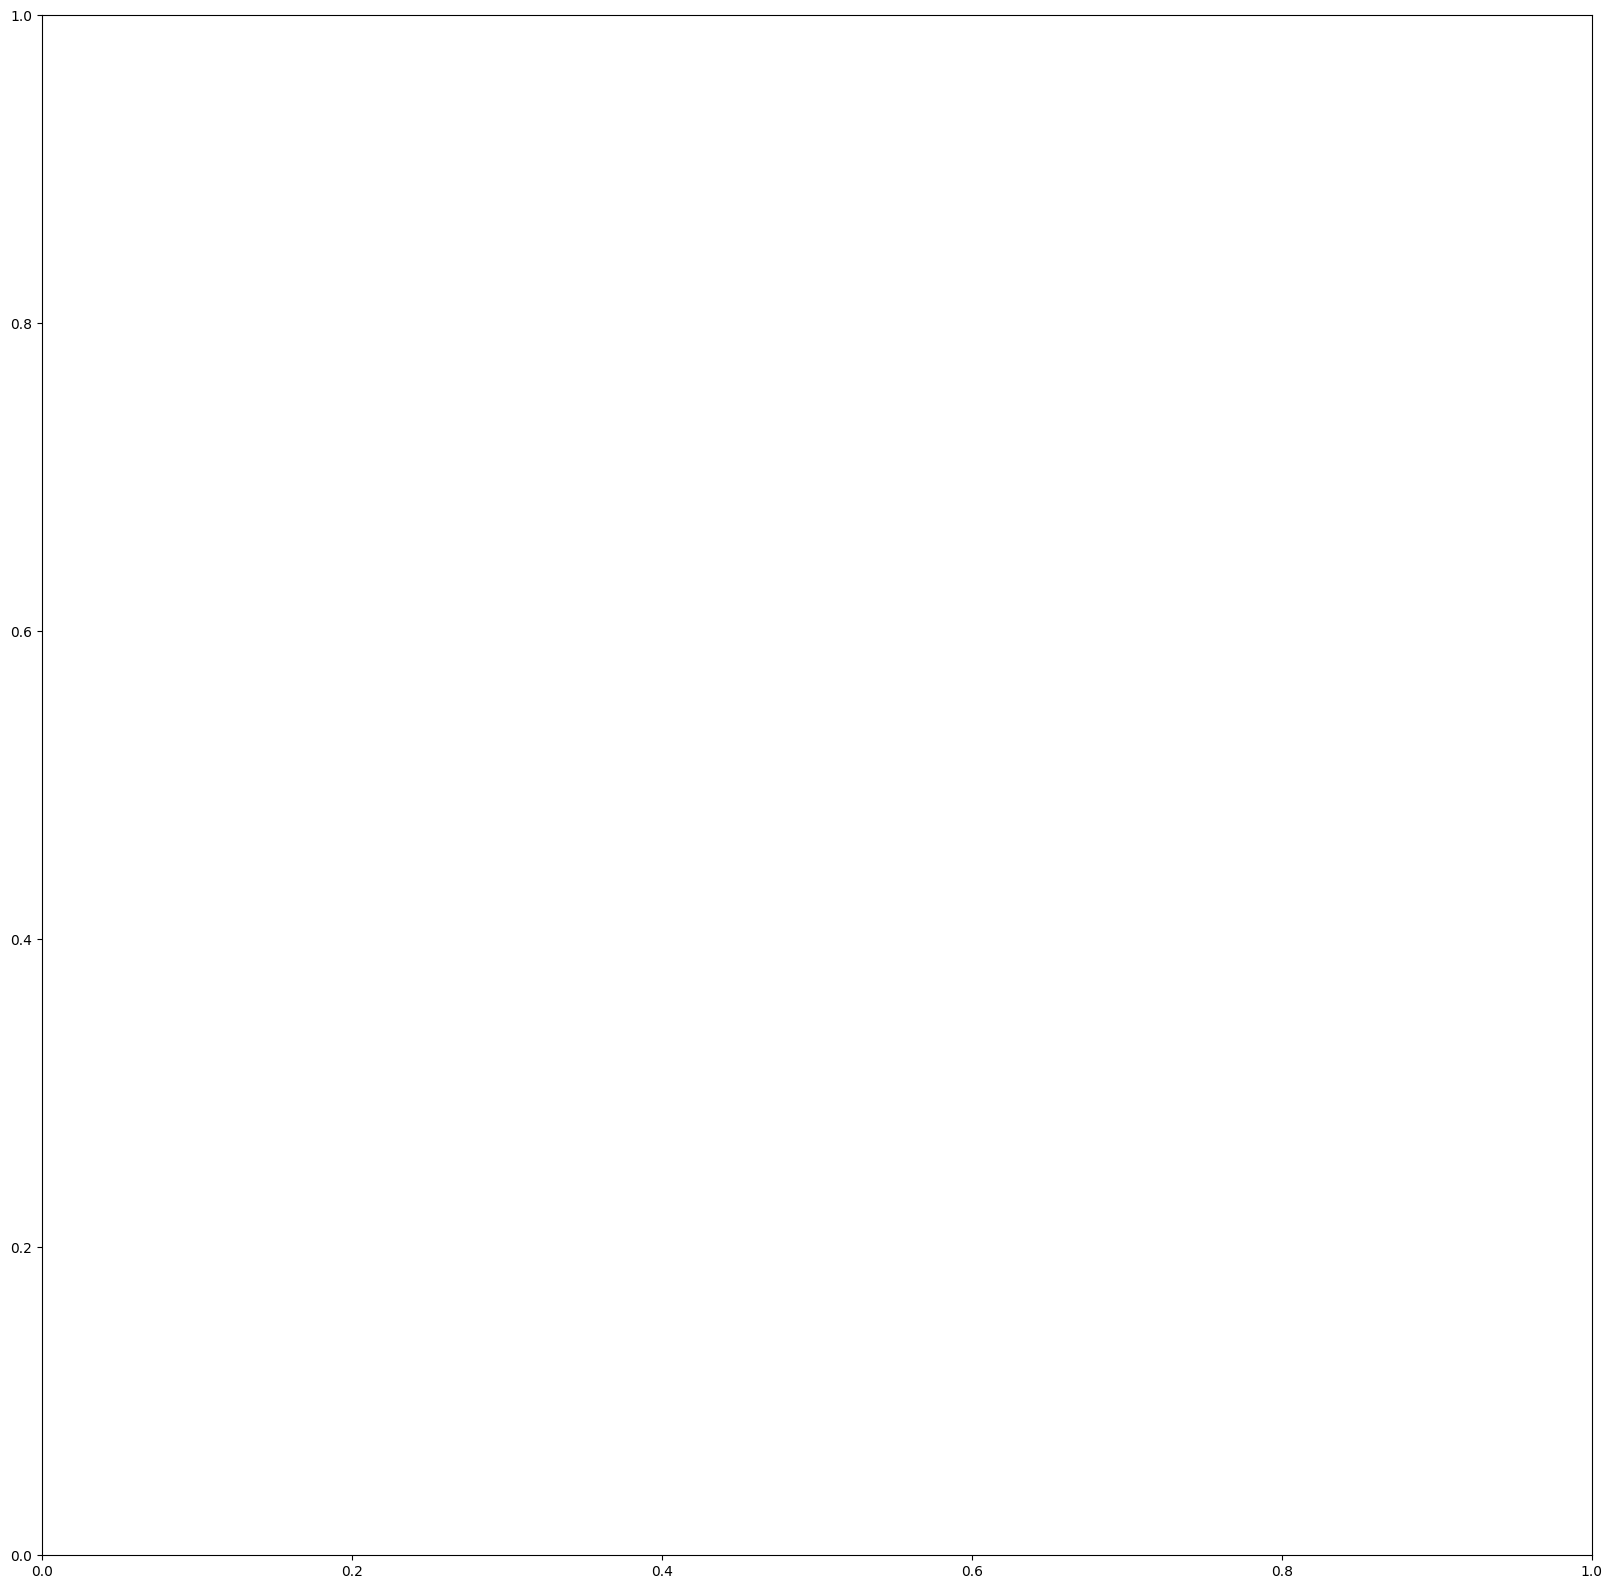

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
       # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)

## Some aggregate feature visualization

### Cleaning for visualizations

In [ ]:
target = 'job' #@param {type:"string"}
target_columns = df_session.columns[~df_session.columns.str.contains(target)]
df_Aggregate = df_session[target_columns].copy()

In [ ]:
target_columns = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime', 'SessionJobsCompleted', 'SwitchJobsCount']
for col in ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']: #'ActiveTime' is not in time.delta, so leaving it out
  df_Aggregate[col] = df_Aggregate[col].dt.total_seconds()

AttributeError: Can only use .dt accessor with datetimelike values

/tmp/ipykernel_1155/309638039.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Aggregate[target_columns].hist(ax=ax)


array([[<Axes: title={'center': 'SessionJobsCompleted'}>,
        <Axes: title={'center': 'SwitchJobsCount'}>]], dtype=object)

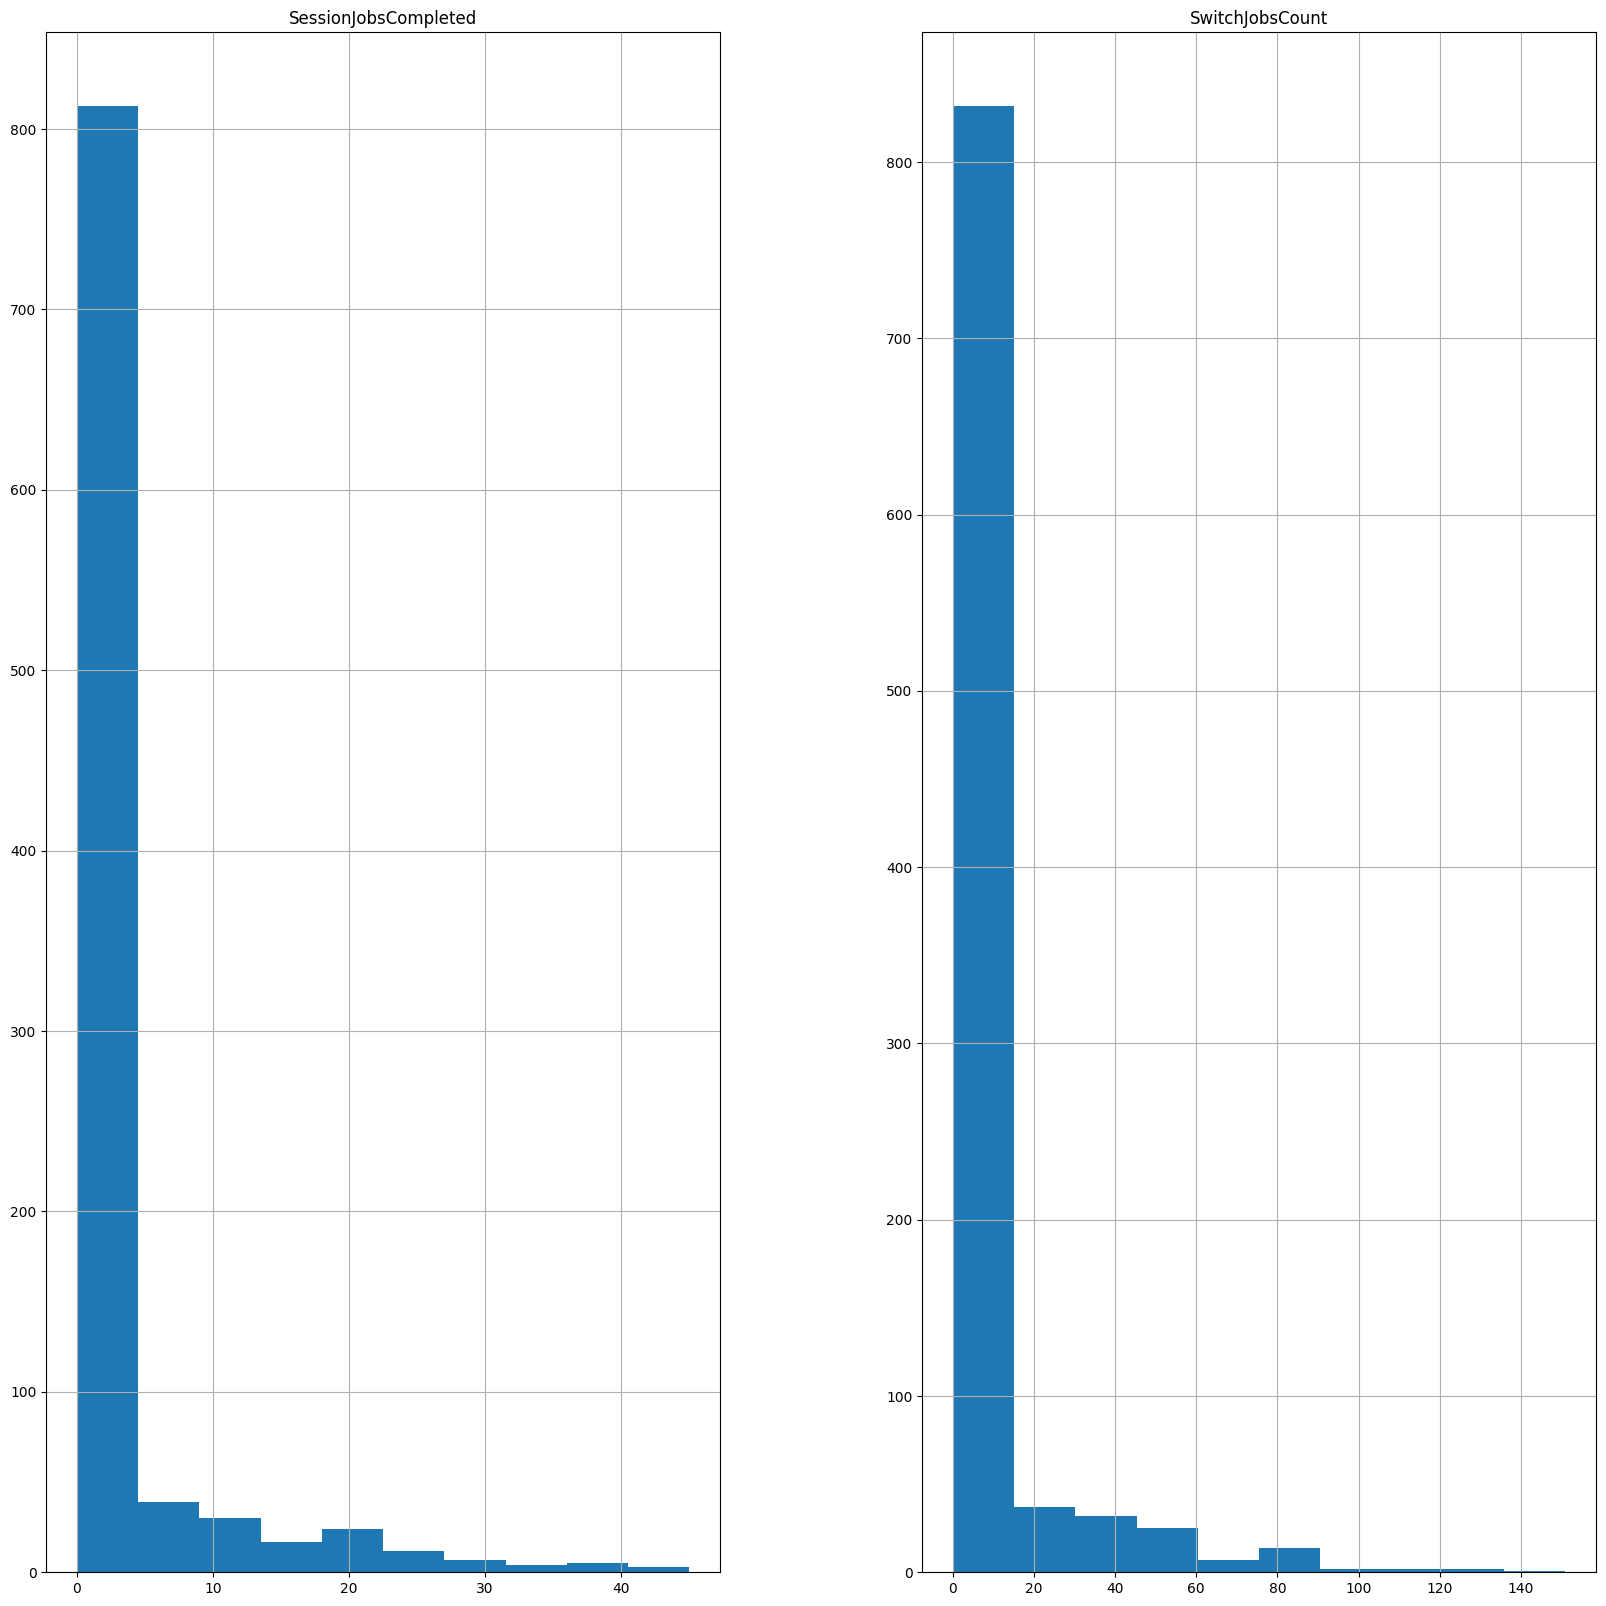

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

Here we find that there may be an outlier in TotalExperimentationTime feature. Let's remove it and impute with 0. For some other data, you can do your own cleaning and use other imputation method.

In [ ]:
sec_outlier = 5000 #@param {type:"integer"}
df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > sec_outlier]

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
Experimentation_columns = df_session.columns[df_session.columns.str.contains("JobExperimentation")]
temp = df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > sec_outlier, Experimentation_columns]
temp

AttributeError: Can only use .dt accessor with datetimelike values

Notice: I used a hacky approach to remove outliers here

In [ ]:
df_Aggregate.TotalExperimentationTime = df_Aggregate.TotalExperimentationTime.mask(df_Aggregate.TotalExperimentationTime>sec_outlier, 0)

/tmp/ipykernel_9469/309638039.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Aggregate[target_columns].hist(ax=ax)


array([[<Axes: title={'center': 'TotalArgumentationTime'}>,
        <Axes: title={'center': 'TotalDiveTime'}>],
       [<Axes: title={'center': 'TotalExperimentationTime'}>,
        <Axes: title={'center': 'SessionJobsCompleted'}>],
       [<Axes: title={'center': 'SwitchJobsCount'}>, <Axes: >]],
      dtype=object)

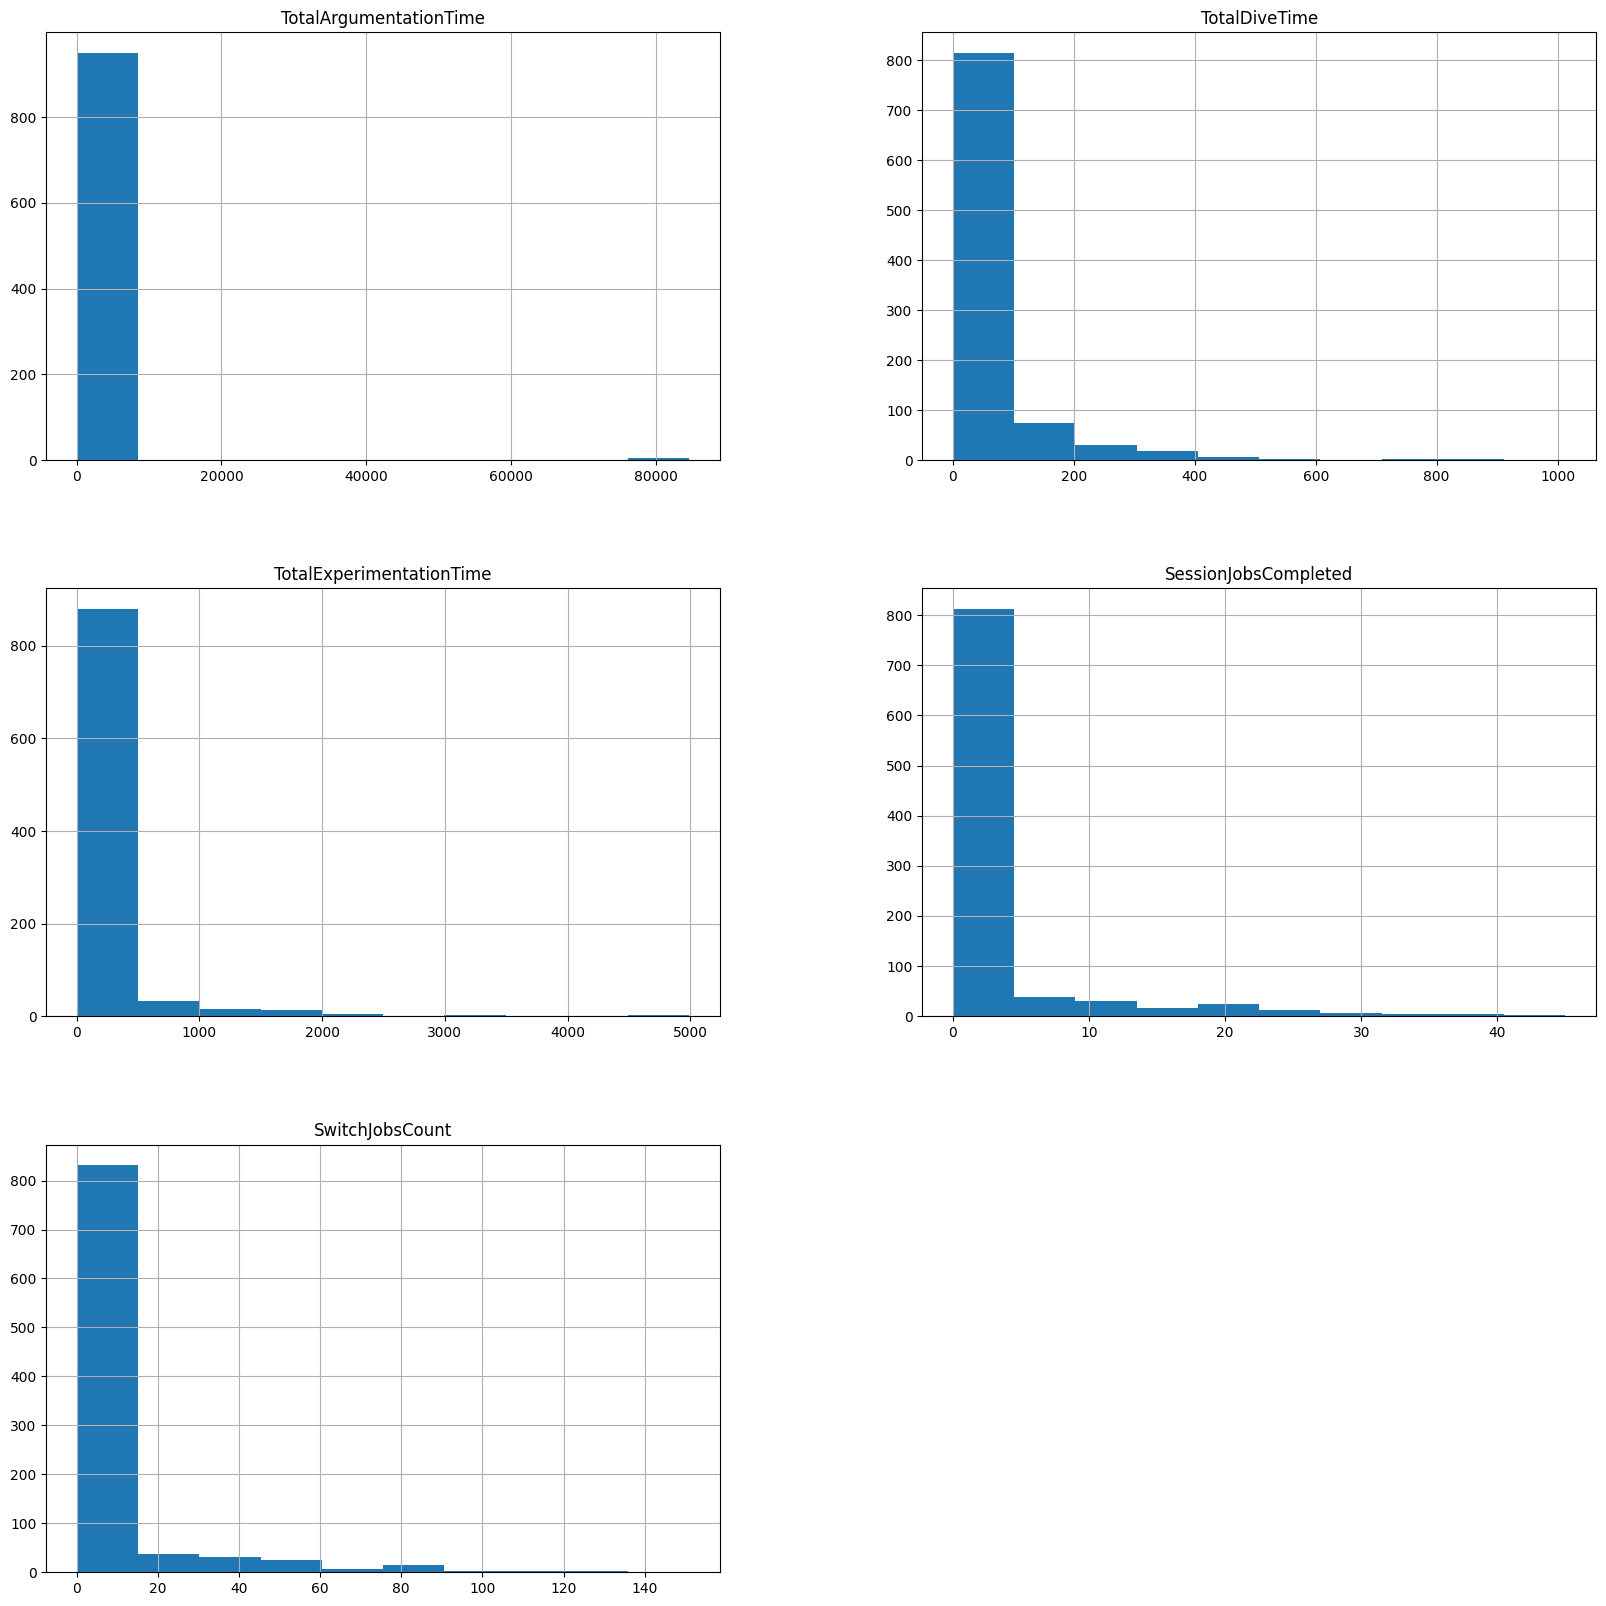

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

In [ ]:
#columns to compare with scatter plot
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

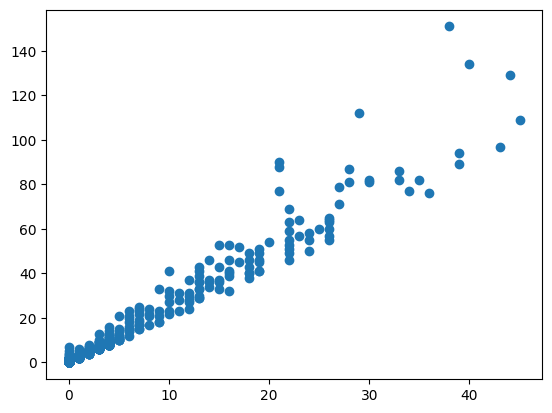

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [ ]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

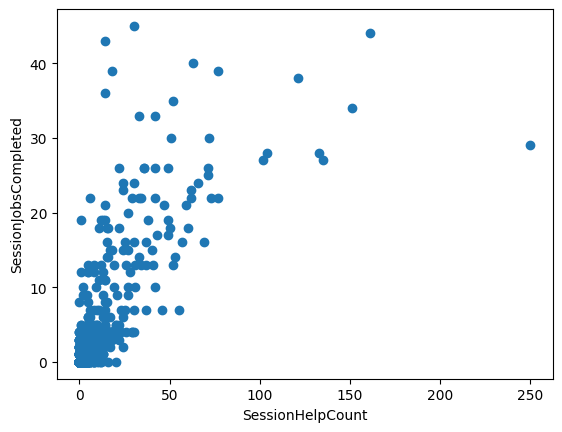

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

In [ ]:
#scatter plot comparing help to jobs_completed/active time
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.ActiveTime) #ActiveTime is a str, can not be divided
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/ActiveTime")

TypeError: unsupported operand type(s) for /: 'int' and 'str'

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [ ]:
#@markdown Choose your own metric for test here
Group_column = "TotalDiveTime" #@param {type:'string'}
Dividing_value = 20 #@param {type: 'int'}
Interested_column = "TotalExperimentationTime" #@param {type: 'string'}

In [ ]:
df_Aggregate['groups'] = df_Aggregate[Group_column].ge(Dividing_value)

In [ ]:
df_Aggregate.shape
df_Aggregate

,index,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration,groups
0,1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0.0,0.0,0.0,92.0,92,False
1,2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",2664.0,677.0,3029.0,5289.833333,31739,True
2,3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",858.0,122.0,480.0,5308.0,10616,True
3,4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",1536.0,197.0,533.0,2271.0,11355,True
4,5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",4867.0,771.0,1881.0,6748.03125,215937,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0.0,0.0,0.0,776.0,776,False
950,951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0.0,0.0,0.0,669.0,669,False
951,952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},264.0,104.0,168.0,1637.5,3275,True
952,953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},175.0,51.0,67.0,1487.0,1487,True


In [ ]:
pairwise = pairwise_tukeyhsd(endog=df_Aggregate[Interested_column], groups=df_Aggregate.groups, alpha=0.05)
print(pairwise)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
 False   True 383.1945   0.0 324.5065 441.8826   True
-----------------------------------------------------


# Machine learning models with Scikit Learn

In [ ]:
response = "SessionJobsCompleted"
predictors = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']

## preprocessing

In [ ]:

x = df_Aggregate[predictors].values
y = df_Aggregate[response].values
std_x = StandardScaler().fit_transform(x)
std_y = StandardScaler().fit_transform(np.array(y)[:,np.newaxis])

## building model

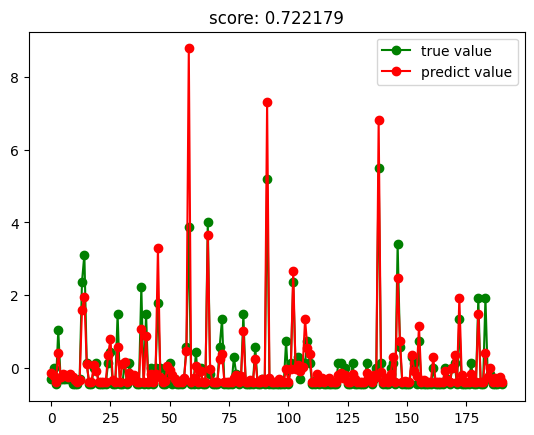

In [ ]:
#linear regression model of train vs test
model = LR()
x_train, x_test, y_train, y_test = train_test_split(std_x, std_y, test_size=0.2, shuffle=True)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
result = model.predict(x_test)
plt.figure()
plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
plt.title('score: %f'%score)
plt.legend()
plt.show()

## Cross validataion

In [ ]:
scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=False)

print(scores.keys())
pprint(scores)

dict_keys(['fit_time', 'score_time', 'test_score'])
{'fit_time': array([0.00238419, 0.00150776, 0.00103688, 0.00113988, 0.00102568]),
 'score_time': array([0.00145578, 0.00050163, 0.00040174, 0.00033879, 0.0005374 ]),
 'test_score': array([0.73349363, 0.62243465, 0.64650076, 0.58301445, 0.77316722])}


# Deep Neural network with Keras

## Classification tasks

### Spliting data

In [ ]:
df_NN = df_Aggregate.copy()
df_NN

,index,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration,groups
0,1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0.0,0.0,0.0,92.0,92,False
1,2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",2664.0,677.0,3029.0,5289.833333,31739,True
2,3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",858.0,122.0,480.0,5308.0,10616,True
3,4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",1536.0,197.0,533.0,2271.0,11355,True
4,5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",4867.0,771.0,1881.0,6748.03125,215937,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0.0,0.0,0.0,776.0,776,False
950,951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0.0,0.0,0.0,669.0,669,False
951,952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},264.0,104.0,168.0,1637.5,3275,True
952,953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},175.0,51.0,67.0,1487.0,1487,True


In [ ]:
Predictors = ['TotalArgumentationTime', 'TotalExperimentationTime',
              'SessionDiveSitesCount',
               'SessionHelpCount'] #ActiveTime not an int
Responses = ['SessionJobsCompleted', "TotalDiveTime"]
cut_value = [1, 20]

In [ ]:
for r, v in zip(Responses, cut_value):
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)

/tmp/ipykernel_3318/2567983929.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)
/tmp/ipykernel_3318/2567983929.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [ ]:
X = df_NN[Predictors]
y = df_NN[['group_' + r for r in Responses]]
X_norm = (X - X.min())/(X.max() - X.min())
X_norm = np.asarray(X_norm).astype('float32')
y_norm = (y - y.min())/(y.max() - y.min())
x_train_full, x_test, y_train_full, y_test = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=True)
x_train.shape

(610, 4)

### Training models

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 300)               1500      
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 31,802
Trainable params: 31,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.003),
              metrics=[keras.metrics.binary_accuracy])

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=40)

Epoch 1/30
16/16 [==============================] - 2s 17ms/step - loss: 0.6863 - binary_accuracy: 0.8582 - val_loss: 0.6837 - val_binary_accuracy: 0.8301
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6807 - binary_accuracy: 0.8582 - val_loss: 0.6784 - val_binary_accuracy: 0.8039
Epoch 3/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6752 - binary_accuracy: 0.8057 - val_loss: 0.6737 - val_binary_accuracy: 0.7712
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6702 - binary_accuracy: 0.7902 - val_loss: 0.6692 - val_binary_accuracy: 0.7549
Epoch 5/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6655 - binary_accuracy: 0.7713 - val_loss: 0.6647 - val_binary_accuracy: 0.7353
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6608 - binary_accuracy: 0.7566 - val_loss: 0.6606 - val_binary_accuracy: 0.7222
Epoch 7/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6

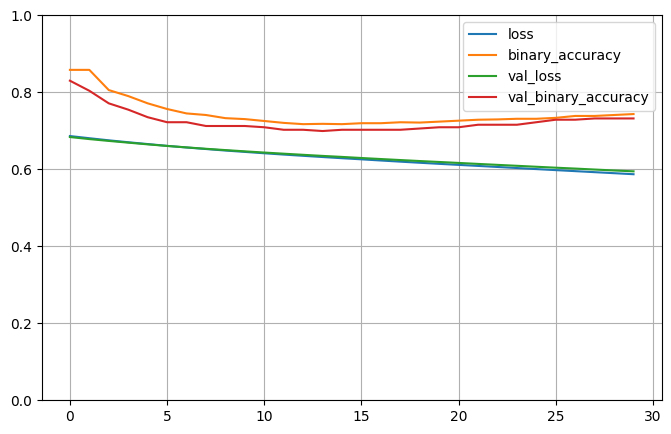

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# SOlution? REsolve

### Evaluation on the test data

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = model.predict(x_test[:3])
print("predictions:", predictions)
print("target_values:", y_test[:3])

Evaluate on test data
6/6 [==============================] - 0s 2ms/step - loss: 0.5694 - binary_accuracy: 0.8063
test loss, test acc: [0.5693773627281189, 0.8062826991081238]
Generate predictions for 2 samples
1/1 [==============================] - 0s 70ms/step
predictions: [[0.3519739  0.38601813]
 [0.35197467 0.38596317]
 [0.35197455 0.38596153]]
target_values:      group_SessionJobsCompleted  group_TotalDiveTime
798                         0.0                  0.0
234                         0.0                  0.0
289                         0.0                  0.0


In [ ]:
predictions = model.predict(x_test)

6/6 [==============================] - 0s 1ms/step


Take SessionJobsCompleted as an example

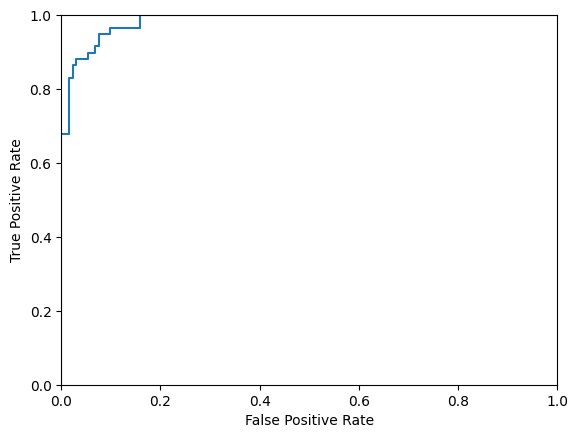

In [ ]:
fpr , tpr , thresholds = roc_curve (y_true=y_test.iloc[:,0], y_score=predictions[:,0])
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 

In [ ]:
print("auc score: ", roc_auc_score(y_test.iloc[:,0], predictions[:,0]))

auc score:  0.9847200821777092
